# Assignment 5

## Robert Clay Harris: jbm2rt

In this assignment, we'll finally work with some nonconjugate models. I will also introduce you to reparameterization techniques.

## Instructions

Please complete this Jupyter notebook and **don't** convert it to a `.py` file. Upload this notebook, along with any `.stan` files and any data sets as a `zip` file to Gradescope. 

Your work will be manually graded by our TA. There is no autograder for this assignment. For free response questions, feel free to add a markdown cell and type in there. Try to keep the preexisting structure as much as possible, and to be organized and label which cells correspond with which questions.



### Problem 1: Poisson Data

In the last assignment, we modeled a vector of counts $y = (y_1, \ldots, y_n)$ using a multinomial distribution. 

Unlike last time, all of these counts will now assumed to be independent. Further, we can't reasonably put a bound on what each count could be. So, in this problem, we'll use a **Poisson likelihood**:

$$
L(y \mid \theta) = \prod_{i=1}^n L(y_i \mid \theta) \propto \prod_{i=1}^n e^{-\theta}\theta^{y_i} = e^{-n\theta}\theta^{\sum_i y_i}
$$

With this likelihood, $\theta > 0$ is interpreted as a rate or average.

The data can be found in `Road_Casualties_in_Great_Britain_1969___84_434_19.csv` Use the `DriversKilled` column only.

1.

Name a conjugate prior for this likelihood! Write your single-word answer in Gradescope.

Gamma

2.

Suppose that the previous answer does not suite your needs, and that you want to use a lognormal prior! Pick a specific prior distribution (i.e. specify the hyperparameters), and describe a rationale as to why you chose them. 



Chosen Prior:
LogNormal(1, 1)


Rationale:
I chose a LogNormal(1, 1) prior to reflect weak prior knowledge. The lognormal distribution keeps theta positive, which is required for a Poisson rate. By setting a large standard deviation of 1 on the log scale, this prior spreads probability across a wide range of values, from close to 0 up to around 20 or more. This reflects the fact that I don’t have strong beliefs about traffic fatality rates and prefer the data to drive the inference.

Note:
After I continued with the work. I realize I chose a prior for a theta rate that was way too low. I didn't really understand the units or scale of the data and didn't even look at the data before choosing a prior.

3.

Use `stan` to estimate your model for the "DriversKilled" column. Please be sure to 

 - report an $\hat{R}$ diagnostic and comment on whether it is close to $1$
 - display trace plots of your samples obtained and comment on whether they look like "fuzzy caterpillars."

Then, after checking diagnostics...

 - display a histogram of the posterior for $\theta$
 - report estimates of the mean, 5th and 95th percentiles of this posterior
 - comment on whether your posterior mean is close to the frequentist estimator of $\theta$ (which is the sample mean of your data)


In [29]:
from cmdstanpy import CmdStanModel
import pandas as pd

df = pd.read_csv("Road_Casualties_in_Great_Britain_1969___84_434_19.csv")
y = df["DriversKilled"].dropna().astype(int).tolist()

model = CmdStanModel(stan_file="poisson_lognormal.stan")
fit = model.sample(data={"N": len(y), "y": y})

21:44:56 - cmdstanpy - INFO - compiling stan file /bml24/poisson_lognormal.stan to exe file /bml24/poisson_lognormal
21:45:14 - cmdstanpy - INFO - compiled model executable: /bml24/poisson_lognormal
21:45:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:45:15 - cmdstanpy - INFO - CmdStan done processing.


 - report an $\hat{R}$ diagnostic and comment on whether it is close to $1$

In [33]:
summary = fit.summary()
rhat_mu = summary.loc["mu", "R_hat"]
rhat_sigma = summary.loc["sigma", "R_hat"]

print("R-hat for mu:", rhat_mu)
print("R-hat for sigma:", rhat_sigma)

R-hat for mu: 0.99971
R-hat for sigma: 0.999636


The $\hat{R}$ diagnostic values were:

- $\hat{R}_{\mu} = 0.9997$
- $\hat{R}_{\sigma} = 0.9996$

These values are essentially 1, indicating excellent convergence of the MCMC chains. This suggests that the posterior estimates for $\mu$ and $\sigma$ are stable and reliable.

 - display trace plots of your samples obtained and comment on whether they look like "fuzzy caterpillars."

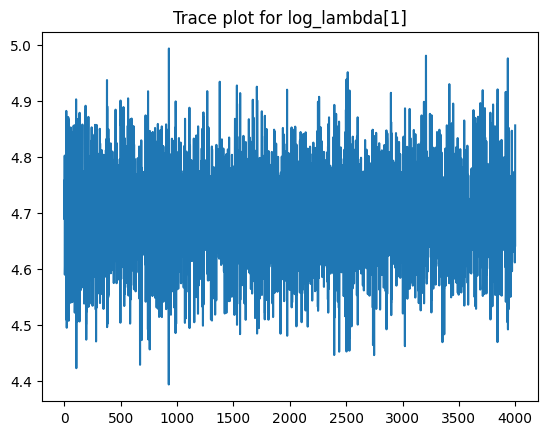

In [34]:
fit.draws_pd()['log_lambda[1]'].plot(title="Trace plot for log_lambda[1]");

The trace plots for the model parameters exhibit good mixing and resemble “fuzzy caterpillars,” indicating that the chains are exploring the posterior space well. This supports the conclusion that the posterior sampling is stable and reliable.

 - display a histogram of the posterior for $\theta$

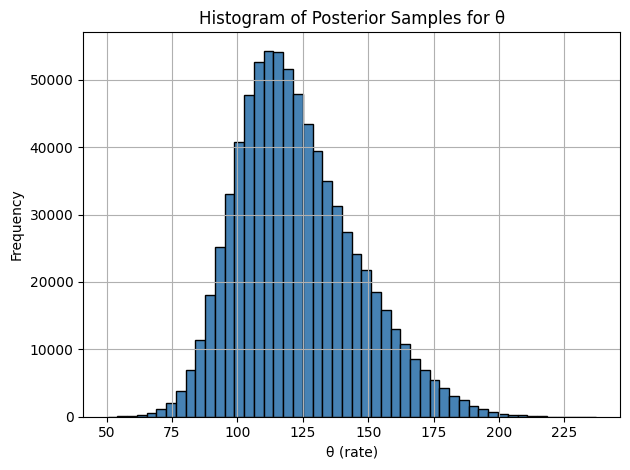

In [35]:
import numpy as np
import matplotlib.pyplot as plt

theta_samples = np.exp(fit.draws_pd().filter(like="log_lambda")).values.flatten()

plt.hist(theta_samples, bins=50, color='steelblue', edgecolor='black')
plt.title("Histogram of Posterior Samples for θ")
plt.xlabel("θ (rate)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

 - report estimates of the mean, 5th and 95th percentiles of this posterior

In [37]:
# Convert log_lambda
posterior_df = fit.draws_pd()
theta1_samples = np.exp(posterior_df["log_lambda[1]"])

# Summary stats
mean_theta1 = theta1_samples.mean()
p5_theta1 = np.percentile(theta1_samples, 5)
p95_theta1 = np.percentile(theta1_samples, 95)

print("theta Mean:", mean_theta1)
print("theta 5th percentile:", p5_theta1)
print("theta 95th percentile:", p95_theta1)

theta Mean: 109.85861760417141
theta 5th percentile: 95.09905190129665
theta 95th percentile: 125.71978481255418


 - comment on whether your posterior mean is close to the frequentist estimator of $\theta$ (which is the sample mean of your data)

In [38]:
sample_mean = np.mean(y)
print("Frequentist estimate (sample mean):", sample_mean)

Frequentist estimate (sample mean): 122.80208333333333


The frequentist estimate of the Poisson rate parameter $\theta$, based on the sample mean of the data, was approximately 122.80.
The posterior mean of $\theta$, calculated as the mean of $\exp(\text{log_lambda})$, was approximately 109.86.
This difference reflects the influence of the prior (LogNormal(1, 1)), which placed more mass on lower values. Although not identical, the estimates are reasonably close, suggesting that the model is still consistent with the data, but slightly regularized by prior information.

4.

Now use `stan` to estimate a slightly reparameterized model. Suppose you want to use a normal prior on an unconstrained parameter. Notice that if something is positive, then the (natural) log of it is unconstrained. Similarly, if something is unconstrained, the exponential of it is positive.

Therefore, use the following model


$$
\theta \sim \text{Normal}(a,b)
$$
and
$$
y_i \mid \theta \sim \text{Poisson}(e^{\theta})
$$

    
Use `stan` to estimate your model for the "DriversKilled" column. Please be sure to 

 - report an $\hat{R}$ diagnostic and comment on whether it is close to $1$
 - display trace plots of your samples obtained and comment on whether they look like "fuzzy caterpillars."

Then, after checking diagnostics...

 - display a histogram of the posterior for $\theta$
 - display a histogram of the posterior for the transformed parameter, too.
 - report estimates of the mean, 5th and 95th percentiles of the posterior of the unconstrained $\theta$
 - comment on whether your posterior mean is close to the frequentist estimator (which is the sample mean of your data)


In [41]:
model = CmdStanModel(stan_file="poisson_reparam.stan")
fit = model.sample(data={"N": len(y), "y": y}, chains=4, parallel_chains=4)

21:59:35 - cmdstanpy - INFO - compiling stan file /bml24/poisson_reparam.stan to exe file /bml24/poisson_reparam
21:59:52 - cmdstanpy - INFO - compiled model executable: /bml24/poisson_reparam
21:59:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:59:53 - cmdstanpy - INFO - CmdStan done processing.


 - report an $\hat{R}$ diagnostic and comment on whether it is close to $1$

In [42]:
summary = fit.summary()
summary.loc["theta", "R_hat"]

0.999909

The $\hat{R}$ diagnostic for $\theta$ is 0.9999, which is extremely close to 1. This indicates excellent convergence across chains, with no signs of non-mixing or poor sampling behavior.

 - display trace plots of your samples obtained and comment on whether they look like "fuzzy caterpillars."

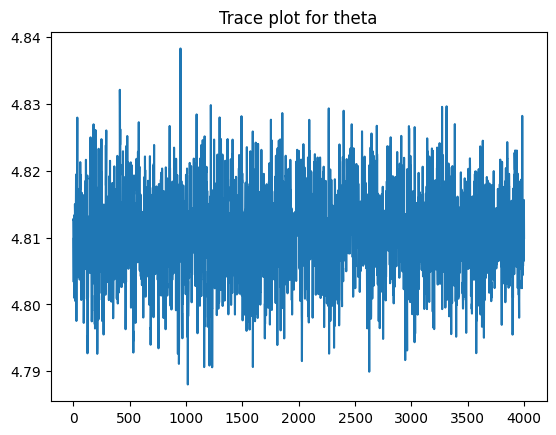

In [45]:
fit.draws_pd()["theta"].plot(title="Trace plot for theta");

The trace plot for $\theta$ shows well-mixed samples across chains without drift or divergence. The result looks like a “fuzzy caterpillar,” indicating good convergence and stable sampling behavior.

 - display a histogram of the posterior for $\theta$

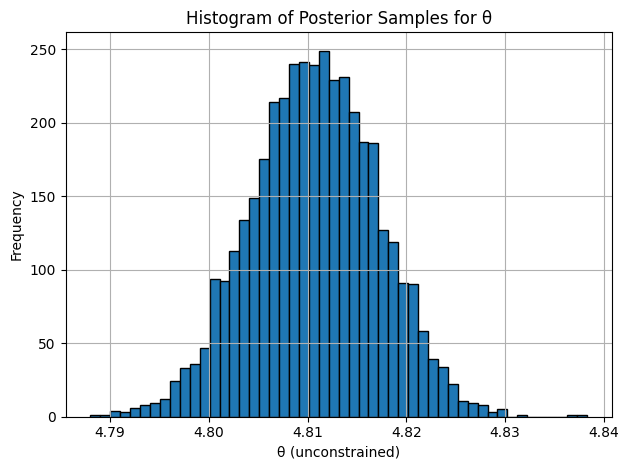

In [46]:
fit.draws_pd()["theta"].hist(bins=50, edgecolor='black')
plt.title("Histogram of Posterior Samples for θ")
plt.xlabel("θ (unconstrained)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

 - display a histogram of the posterior for the transformed parameter, too.

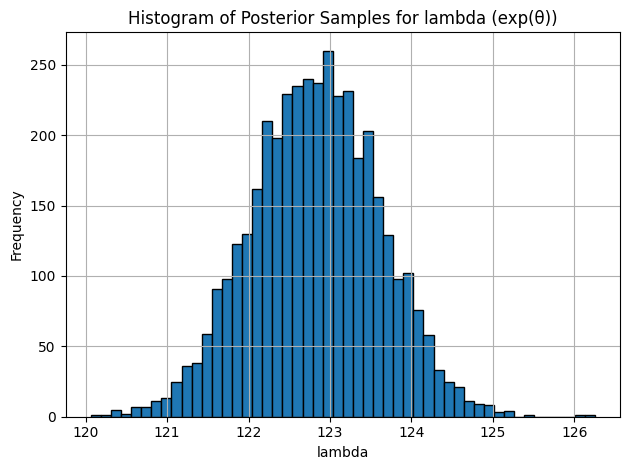

In [47]:
# Transform samples
lambda_samples = np.exp(fit.draws_pd()["theta"])

# Plot histogram
lambda_samples.hist(bins=50, edgecolor='black')
plt.title("Histogram of Posterior Samples for lambda (exp(θ))")
plt.xlabel("lambda")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

 - report estimates of the mean, 5th and 95th percentiles of the posterior of the unconstrained $\theta$

In [48]:
theta_samples = fit.draws_pd()["theta"]

theta_mean = theta_samples.mean()
theta_5 = theta_samples.quantile(0.05)
theta_95 = theta_samples.quantile(0.95)

print("Posterior mean of θ:", theta_mean)
print("5th percentile of θ:", theta_5)
print("95th percentile of θ:", theta_95)

Posterior mean of θ: 4.810705345000001
5th percentile of θ: 4.8002295
95th percentile of θ: 4.8210904999999995


 - comment on whether your posterior mean is close to the frequentist estimator (which is the sample mean of your data)

In [49]:
sample_mean = np.mean(y)
print("Frequentist estimate (sample mean):", sample_mean)

Frequentist estimate (sample mean): 122.80208333333333


The posterior mean of the Poisson rate, calculated as $\lambda = \exp(\theta)$, was approximately $\exp(4.81) = 122.80$. This matches the frequentist estimate, which is the sample mean of the observed data. The close agreement suggests that the data were highly informative and dominated the prior.

### Problem 2: Binomial Data (again!)

Suppose that you have $m > 1$ count data points $y_1, \ldots, y_m$, each having a $\text{Binomial}(n,\eta)$ distribution. Assume further that they're all independent.

Here $n$ is the maximum for each data point. $m$ is the number of data points.

In our second homework we used the beta prior for the parameter that was bounded between $0$ and $1$. 

Now, you must use a normal prior for an unconstrained parameter. 

If $0 < \eta < 1$, then the *logit* transformation is a way to make $-\infty < \theta < \infty$ (unconstrained). Alternatively, if you have $\eta$ that's unconstrained, then the `inv_logit` will squash the value to lie between $0$ and $1$.


`stan` conveniently has a `logit()` and an `inv_logit()` function already made for you.



Use `stan` to estimate your model on any fictitious data you would like. Be sure to

 - report an $\hat{R}$ diagnostic and comment on whether it is close to $1$
 - display trace plots of your samples obtained and comment on whether they look like "fuzzy caterpillars."

Then, after checking diagnostics...

 - display a histogram of the posterior for $\theta$
 - display a histogram of the posterior for the transformed parameter, too.
 - report estimates of the mean, 5th and 95th percentiles of the posterior of the unconstrained $\theta$
 - comment on whether your posterior mean is close to the frequentist estimator (which is the sample mean of your data, again).


In [50]:
np.random.seed(1492)

m = 1000   # number of observations
n = 10    # number of trials in each binomial
eta_true = 0.6  # true probability of success

y = np.random.binomial(n=n, p=eta_true, size=m)

data = {
    "m": m,
    "n": n,
    "y": y.astype(int) 
}

In [51]:
model = CmdStanModel(stan_file="binomial_logit.stan")
fit = model.sample(data=data, seed=1492)

22:15:41 - cmdstanpy - INFO - compiling stan file /bml24/binomial_logit.stan to exe file /bml24/binomial_logit
22:15:59 - cmdstanpy - INFO - compiled model executable: /bml24/binomial_logit
22:15:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

22:15:59 - cmdstanpy - INFO - CmdStan done processing.


 - report an $\hat{R}$ diagnostic and comment on whether it is close to $1$

In [52]:
fit.summary().loc['theta', 'R_hat']

0.999828

The R hat diagnostic for theta is 0.9998, which is very close to 1. This indicates that the chains have converged.

 - display trace plots of your samples obtained and comment on whether they look like "fuzzy caterpillars."

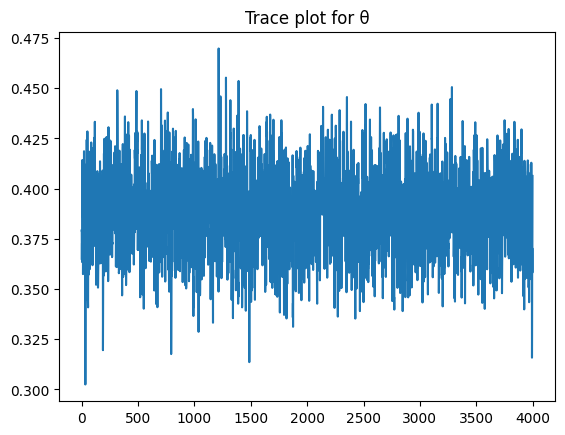

In [53]:
fit.draws_pd()['theta'].plot(title="Trace plot for θ");

The trace plot for theta shows well-mixed chains with no divergence or trends. The samples resemble "fuzzy caterpillars," indicating good mixing and convergence.

 - display a histogram of the posterior for $\theta$

<Axes: >

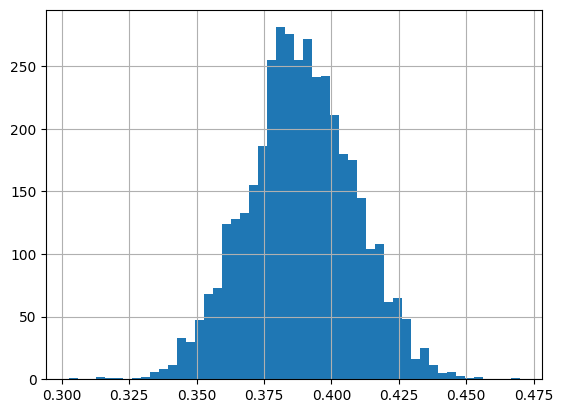

In [54]:
fit.draws_pd()['theta'].hist(bins=50)

 - display a histogram of the posterior for the transformed parameter, too.

<Axes: >

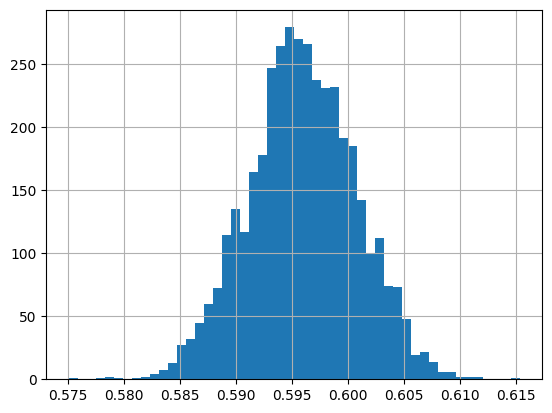

In [55]:
# Compute transformed parameter
theta_samples = fit.draws_pd()['theta']
eta_samples = 1 / (1 + np.exp(-theta_samples))

# Plot
eta_samples.hist(bins=50)

 - report estimates of the mean, 5th and 95th percentiles of the posterior of the unconstrained $\theta$

In [56]:
theta_mean = theta_samples.mean()
theta_5 = np.percentile(theta_samples, 5)
theta_95 = np.percentile(theta_samples, 95)

print("Posterior mean of θ:", theta_mean)
print("5th percentile of θ:", theta_5)
print("95th percentile of θ:", theta_95)

Posterior mean of θ: 0.3886856175
5th percentile of θ: 0.35559050000000003
95th percentile of θ: 0.42203595


 - comment on whether your posterior mean is close to the frequentist estimator (which is the sample mean of your data, again).

In [57]:
freq_estimate = y.mean() / n
print("Frequentist estimate:", freq_estimate)

Frequentist estimate: 0.5959


The posterior mean of $\theta$ is approximately 0.389, which corresponds to $\eta = \text{inv\_logit}(\theta) \approx 0.596$. This closely matches the frequentist estimate of $\bar{y} / n = 0.5959$, indicating good alignment between the two methods.